# **Predicting High School Mathematics Performance Using the UC Irvine 'Student Performance' Dataset**

In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random; random.seed(10) # pre-setting seed
from scipy import stats
from scipy.stats import norm, chi2, f

# For model fitting
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

# Model evaluation
from sklearn.metrics import *

# Ordered choice model
from statsmodels.miscmodels.ordinal_model import OrderedModel

# For R kernel
import rpy2.ipython
%load_ext rpy2.ipython

# **Introduction**


*   Using the "Student Performance" dataset from UC Irvine, we will attempt to predict whether a student will pass or fail mathematics in their final high school year.
*   The outcome variable, G3, is the variable for grades in mathematics in the final year of high school. The dataset gives grades 0-20, which we will use to create a binary for pass/fail. A passing grade is 10 or greater, and G3>9 will = 1 in our G3_binary. If G3 is less than 10, the student has failed, and G3 binary = 0.
*   Demographic attributes, socioeconomic factors, and previous performance will be our regressors.



# **Data Preparation**

In [5]:
# Uploading data
from google.colab import files
data = files.upload()

Saving studentdata.csv to studentdata.csv


In [6]:
# Loading data
data = pd.read_csv('studentdata.csv')

# Deleting variables with unbalanced binaries
columns_delete = ['failures_x', 'address', 'internet', 'nursery', 'Dalc_x', 'health_x']
data = data.drop(columns=columns_delete, errors='ignore')

#dataframe info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   sex           382 non-null    int64
 1   age           382 non-null    int64
 2   famsize       382 non-null    int64
 3   Pstatus       382 non-null    int64
 4   Medu          382 non-null    int64
 5   Fedu          382 non-null    int64
 6   traveltime_x  382 non-null    int64
 7   studytime_x   382 non-null    int64
 8   schoolsup_x   382 non-null    int64
 9   famsup_x      382 non-null    int64
 10  paid_x        382 non-null    int64
 11  activities_x  382 non-null    int64
 12  higher_x      382 non-null    int64
 13  romantic_x    382 non-null    int64
 14  famrel_x      382 non-null    int64
 15  freetime_x    382 non-null    int64
 16  goout_x       382 non-null    int64
 17  Walc_x        382 non-null    int64
 18  absences_x    382 non-null    int64
 19  G1_x          382 non-null   

# **Descriptive Analysis: Exploring Key Predictors of Student Performance**

## Columns of Interest (with Explanation)

### Demographic Factors:
- **sex**: Student's sex (1 for female, 0 for male)
- **age**: Student's age (15 to 22 years)
- **Pstatus**: Parent's cohabitation status (1 = living together, 0 = apart)

### Socioeconomic Factors:
- **Medu**: Mother's education (0 to 4 scale)
- **Fedu**: Father's education (0 to 4 scale)
- **famsize**: Family size (1 if greater than 3, otherwise 0)
- **famrel**: Quality of family relationships (1 = very bad, 5 = excellent)

### Academic Support and Activities:
- **schoolsup_x**: Extra educational school support (1 = yes, 0 = no)
- **famsup_x**: Family educational support (1 = yes, 0 = no)
- **paidclass**: Extra paid classes (1 = yes, 0 = no)
- **activities_x**: Participation in extracurricular activities (1 = yes, 0 = no)
- **higher_x**: Aspiration to pursue higher education (1 = yes, 0 = no)

### Behavioral and Lifestyle Factors:
- **studytime_x**: Weekly study time (1 = <2 hours, 2 = 2–5 hours, 3 = 5–10 hours, 4 = >10 hours)
- **traveltime_x**: Home-to-school travel time (1 = <15 min, 2 = 15–30 min, 3 = 30 min–1 hour, 4 = >1 hour)
- **freetime_x**: Free time after school (1 = very low, 5 = very high)
- **goout_x**: Frequency of going out with friends (1 = very low, 5 = very high)
- **romantic_x**: In a romantic relationship (1 = yes, 0 = no)
- **Walc_x**: Weekend alcohol consumption (1 = very low, 5 = very high)
- **absences_x**: Number of school absences (0 to 93)

### Performance Metrics:
- **G1_x**: First period grade (0 to 20)
- **G2_x**: Second period grade (0 to 20)
- **G3_binary**: Final grade as a binary (1 = pass if G3 > 9, 0 = fail if G3 ≤ 9)


In [7]:
# Setting variables of interest as predictors
predictors = data[['sex', 'age', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'traveltime_x', 'studytime_x', 'schoolsup_x',
                   'famsup_x', 'paid_x', 'activities_x', 'higher_x', 'romantic_x', 'famrel_x',
                   'freetime_x', 'goout_x', 'Walc_x', 'absences_x', 'G1_x', 'G2_x']]

# Converting G3 into a binary variable: G3 = 1 if G3>9, G3=0 otherwise (a score of 10 or greater indicates that the student passed)
data['G3_binary'] = (data['G3_x'] > 9).astype(int)

In [8]:
describe = pd.concat([predictors, data['G3_binary']], axis=1)
describe.describe()

,sex,age,famsize,Pstatus,Medu,Fedu,traveltime_x,studytime_x,schoolsup_x,famsup_x,...,higher_x,romantic_x,famrel_x,freetime_x,goout_x,Walc_x,absences_x,G1_x,G2_x,G3_binary
count,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,...,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,0.518325,16.586387,0.727749,0.900524,2.806283,2.565445,1.442408,2.034031,0.133508,0.623037,...,0.952880,0.316754,3.939791,3.222513,3.112565,2.280105,5.319372,10.861257,10.712042,0.667539
std,0.500319,1.173470,0.445702,0.299693,1.086381,1.096240,0.695378,0.845798,0.340569,0.485261,...,0.212174,0.465821,0.921620,0.988233,1.131927,1.282866,7.625251,3.349167,3.832560,0.471713
min,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,0.000000,16.000000,0.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,0.000000,8.000000,8.250000,0.000000
50%,1.000000,17.000000,1.000000,1.000000,3.000000,3.000000,1.000000,2.000000,0.000000,1.000000,...,1.000000,0.000000,4.000000,3.000000,3.000000,2.000000,3.000000,10.500000,11.000000,1.000000
75%,1.000000,17.000000,1.000000,1.000000,4.000000,4.000000,2.000000,2.000000,0.000000,1.000000,...,1.000000,1.000000,5.000000,4.000000,4.000000,3.000000,8.000000,13.000000,13.000000,1.000000
max,1.000000,22.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,1.000000


### Outcome Variable
- Our dependent variable is G3_binary, the pass/fail binary variable we created from the final grade in the third year of high school. The dataset was collected in a Portuguese education system where grades may range from 0 to 20. A score of 10 or higher is a pass, and anything below 10 is a fail. We create the binary variable 'G3_binary' by converting G3_x into 1 for scores of 10 and above (*pass* ), 0 otherwise (*fail* ).

- Our 'G3_binary' is slightly imbalanced, with nearly 67% of the observations representing students who passed. The unbalanced data is relatively expected, as we would expect most students to pass in their final year.

- Our dataset does not have any null values.

### Predictors
- The sample is very well balanced between sexes, with 52% of individuals being females. The sample's age range lies between 15 to 22, with an average of almost 17 years old. We notice the age variable is strongly skewed towards the younger age, as expected for a sample of high school students.
- About 73% of our sample represents families with more than 3 members. About 90% of parents live together, so the sample is not representative of predicting the probability of passing depending on the parents' relationship status.
- Travel time, study time, school support, and family support are slightly skewed toward lower values because means are closer to the minimum.
- Almost all in the sample (95%) want to pursue a higher education.

# Binary variable distribution

The histograms below show the distribution of our binary variables. We assess the distribution of our binaries as a severe imbalance between the two possible outcomes would reduce the variable's explanatory power to our model. Ideally, each would be balanced close to a 50/50 split.

After examining the histograms, the binary variables can be categorized as follows:

### Well-balanced:
These variables have a roughly equal distribution and are suitable for modeling:
- **Student's sex** (1 = female, 0 = male)
- **Family educational support** (1 = yes, 0 = no)
- **Extra paid classes** (1 = yes, 0 = no)
- **Participation in extracurricular activities** (1 = yes, 0 = no)

### Slightly imbalanced (not a major concern):
These variables show some imbalance but are still acceptable for analysis:
- **In a romantic relationship** (1 = yes, 0 = no)
- **Final grade as a binary** (1 = pass if G3 > 9, 0 = fail if G3 ≤ 9)

### Imbalanced and potentially problematic:
These variables show a significant imbalance, which may limit their predictive utility:
- **Family size** (1 = if greater than 3, otherwise 0)
- **Parent's cohabitation status** (1 = living together, 0 = apart)
- **Aspiration to pursue higher education** (1 = yes, 0 = no)
- **Extra educational school support** (1 = yes, 0 = no)


In [21]:
binary_vars = ['sex', 'famsize', 'Pstatus', 'schoolsup_x', 'famsup_x', 'paid_x', 'activities_x', 'higher_x', 'romantic_x', 'G3_binary']

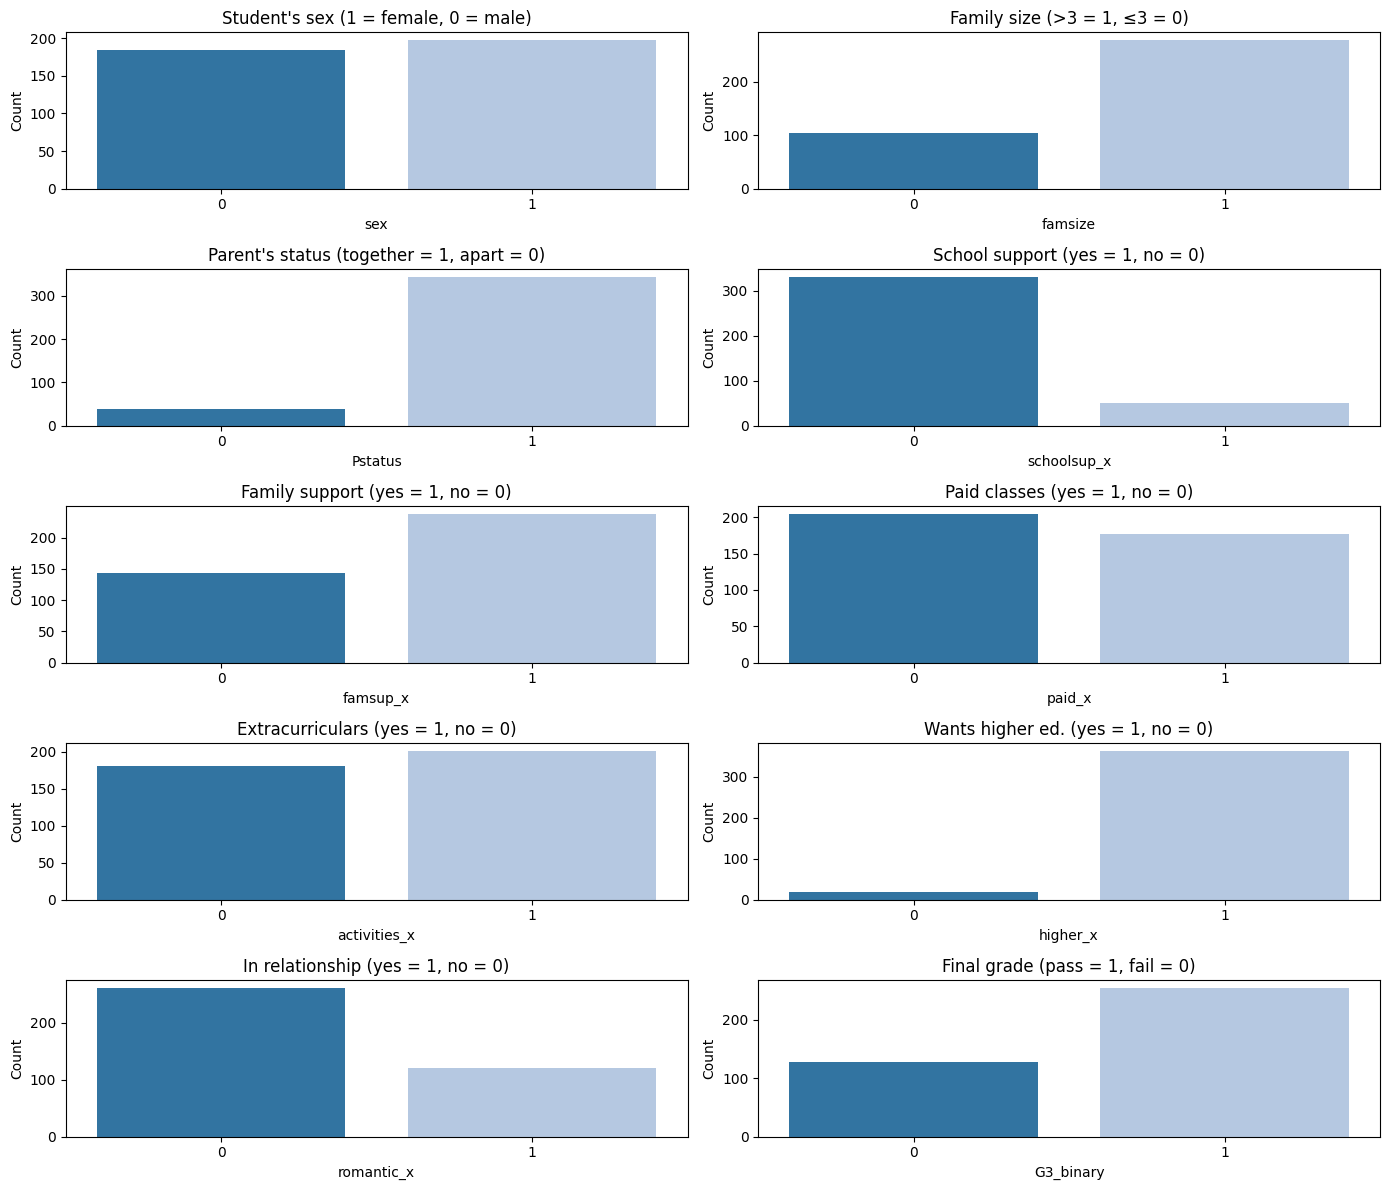

In [22]:
var_explanations = {
    'sex': "Student's sex (1 = female, 0 = male)",
    'famsize': "Family size (>3 = 1, ≤3 = 0)",
    'Pstatus': "Parent's status (together = 1, apart = 0)",
    'schoolsup_x': "School support (yes = 1, no = 0)",
    'famsup_x': "Family support (yes = 1, no = 0)",
    'paid_x': "Paid classes (yes = 1, no = 0)",
    'activities_x': "Extracurriculars (yes = 1, no = 0)",
    'higher_x': "Wants higher ed. (yes = 1, no = 0)",
    'romantic_x': "In relationship (yes = 1, no = 0)",
    'G3_binary': "Final grade (pass = 1, fail = 0)"
}

fig, axes = plt.subplots(nrows=len(binary_vars)//2, ncols=2, figsize=(14, 12))
axes = axes.flatten()

palette = ['#1f77b4', '#aec7e8']

for i, var in enumerate(binary_vars):
    sns.countplot(x=var, hue=var, data=data, palette=palette, legend=False, ax=axes[i])
    axes[i].set_title(var_explanations[var])
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel(var)

plt.tight_layout()
plt.show()


# Non-binary Variable Distribution

### The distributions of our non-binary variables illustrate our discrete independent variables, many of which are categorical. Each illustrates the following:

*   Free time, going out, study time, first period grade (G1), and second period grade (G2) are our variables with distributions closest to a bell shape. Free time, going out, and study time are all categorical variables. G1 and G2 are both discrete variables with the grade range of 0 to 20. This matches what we would expect, with grading often curved to a somewhat normal distribution on purpose.
*   Data on absences is heavily right-skewed, with the majority of students having 0 absences. This may require a log or exponential transformation.
*   Age shows clustering around the typical school ages of 16, 17, and 18, with a few older students on the far right side of the distribution.
*   The rest of the variables—mother's education, father's education, travel time, family relationships, free time, going out, and weekend alcohol consumption—are all discrete and categorical variables. These distributions are helpful for contextualizing our data, but it is important to note that such variables are rarely transformed. Because of this, we will skip Cullen Frey graphs.


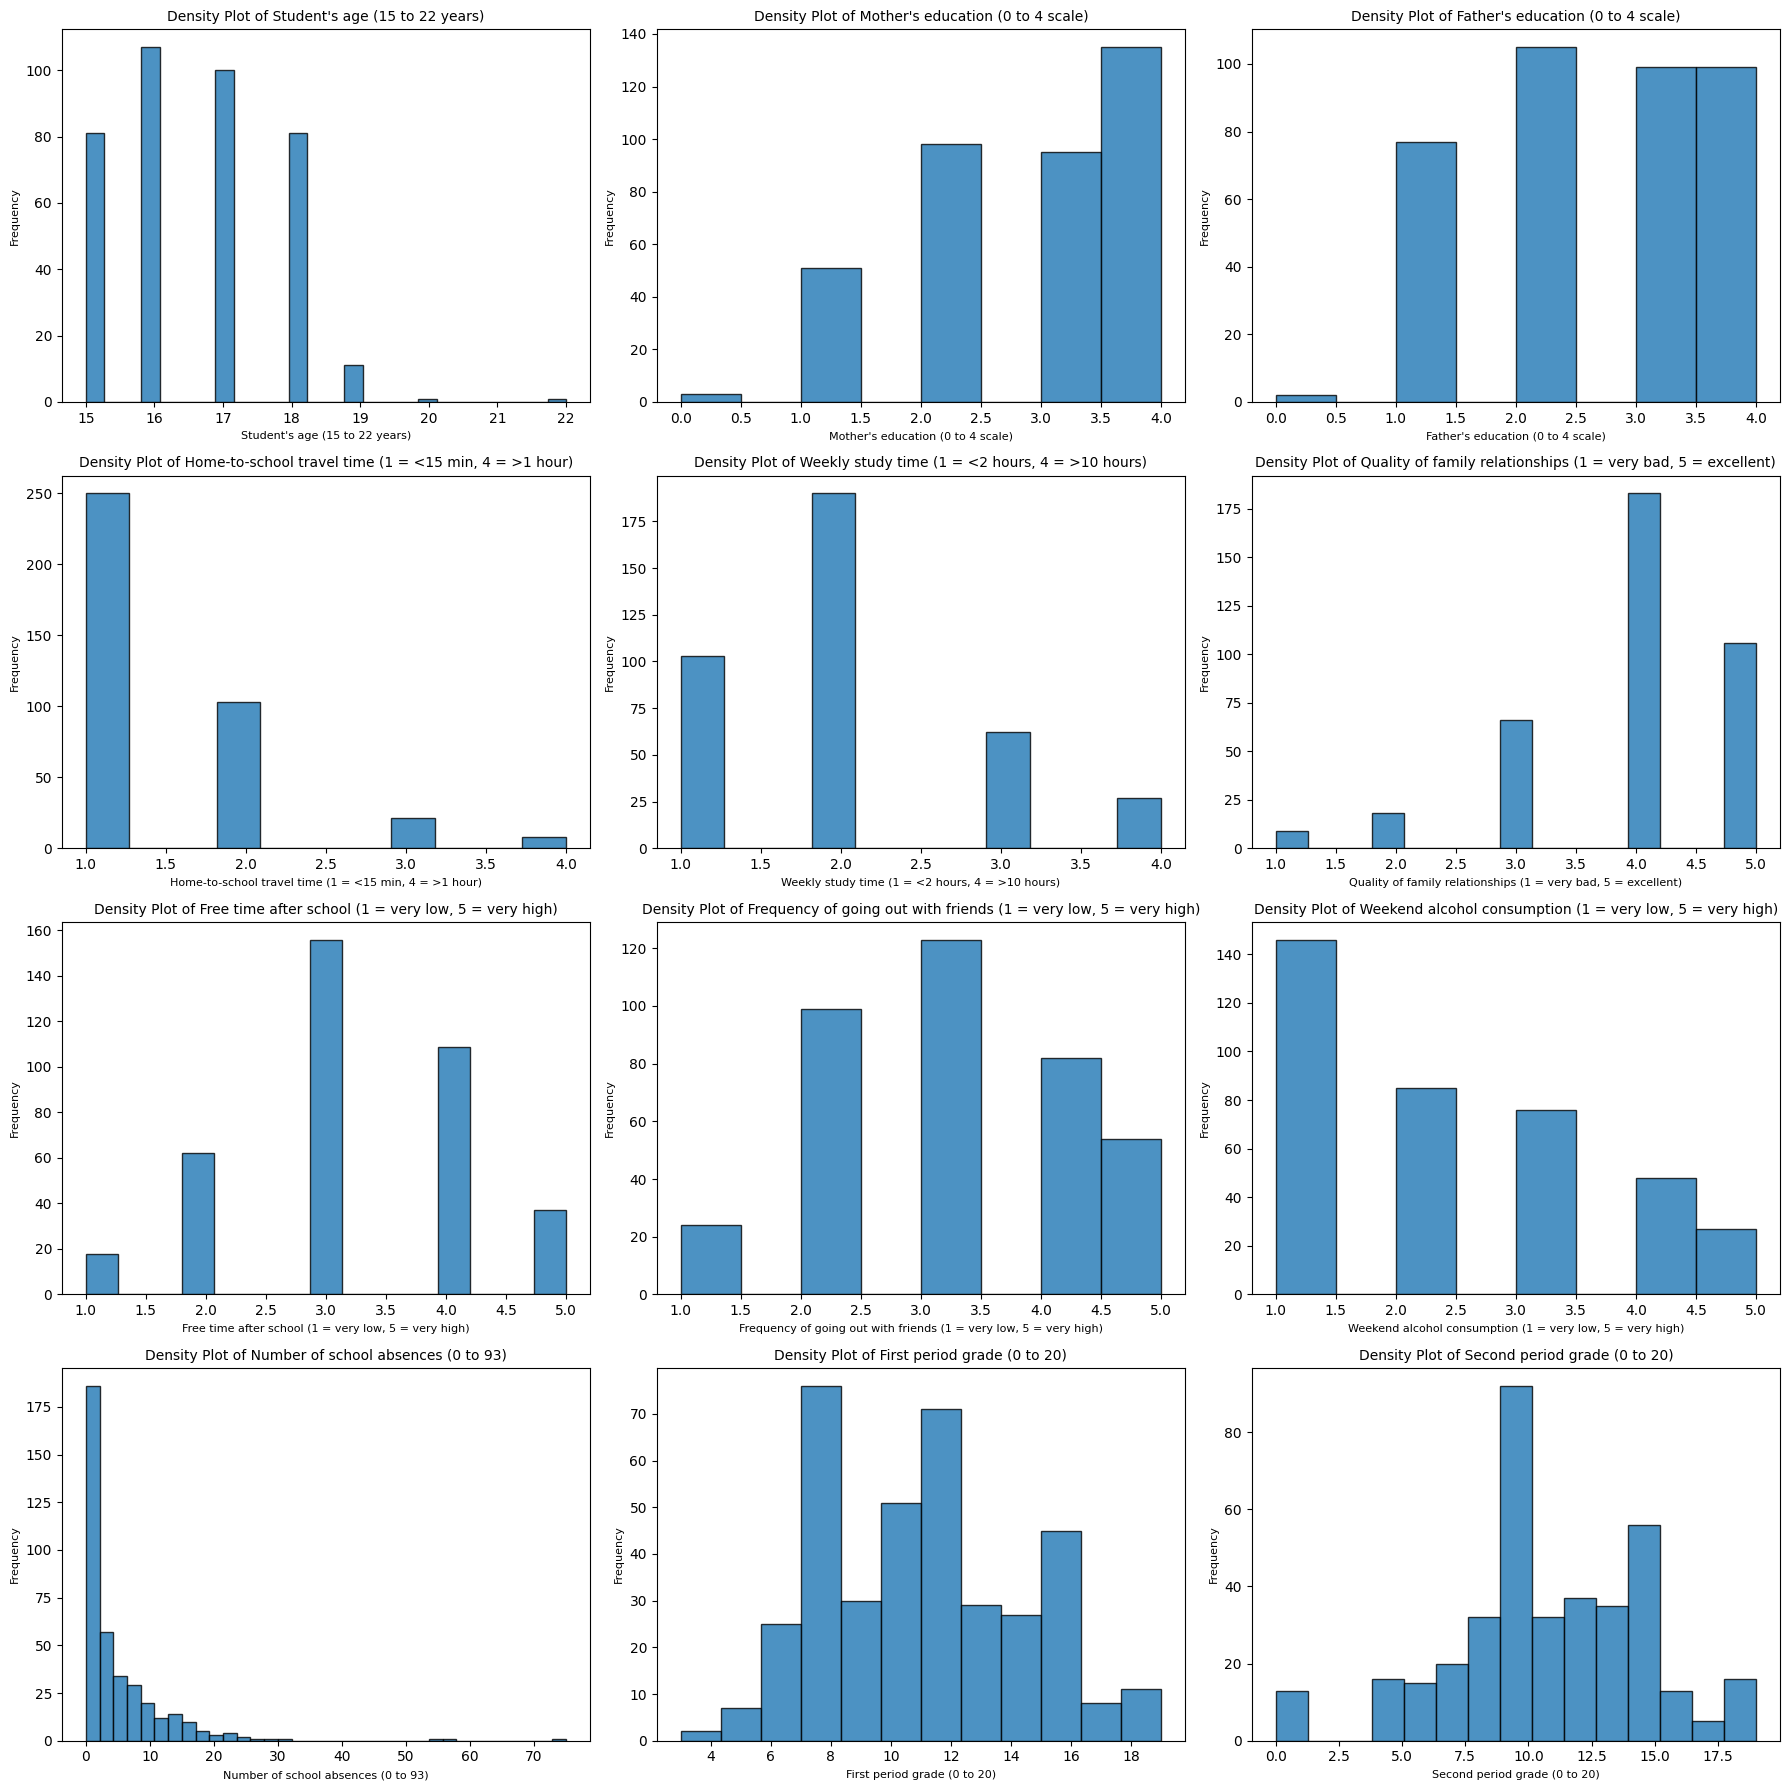

In [10]:
variables = {
    'age': "Student's age (15 to 22 years)",
    'Medu': "Mother's education (0 to 4 scale)",
    'Fedu': "Father's education (0 to 4 scale)",
    'traveltime_x': "Home-to-school travel time (1 = <15 min, 4 = >1 hour)",
    'studytime_x': "Weekly study time (1 = <2 hours, 4 = >10 hours)",
    'famrel_x': "Quality of family relationships (1 = very bad, 5 = excellent)",
    'freetime_x': "Free time after school (1 = very low, 5 = very high)",
    'goout_x': "Frequency of going out with friends (1 = very low, 5 = very high)",
    'Walc_x': "Weekend alcohol consumption (1 = very low, 5 = very high)",
    'absences_x': "Number of school absences (0 to 93)",
    'G1_x': "First period grade (0 to 20)",
    'G2_x': "Second period grade (0 to 20)"
}

fig, ax = plt.subplots(4, 3, figsize=(18, 18))
ax = ax.flatten()

for i, var in enumerate(variables.keys()):
    if i < len(variables):
        ax[i].hist(data[var], color='#1f77b4', alpha=0.8, bins='fd', edgecolor='black')
        ax[i].set_title(f'Density Plot of {variables[var]}', fontsize=10)
        ax[i].set_xlabel(variables[var], fontsize=8)
        ax[i].set_ylabel('Frequency', fontsize=8)

for j in range(len(variables), len(ax)):
    ax[j].axis('off')

plt.tight_layout()
plt.show()


# **Cullen and Frey Plots**
We will go through the Cullen Frey and fitter diagnostics to get a better understanding of the distributions of our data, but as previously noted, categortical variables are transformed rarely. Therefore, our analysis most likely will not result in transformations.

## The Cullen Frey graphs below suggest the following:

*   **Age**: The distribution of age data is close to the normal distribution with the bootstrapped estimates spread across uniform, normal, lognormal and gamma.
*   **Mother's educ**: Mother's education data and bootstrapped estimates lie very closely to the uniform distribution.
*   **Father's educ**: Data and bootstrapped estimates both fall directly on the uniform distribution.
*   **G1_x**: Data and bootstrapped estimates fall between normal and uniform distributions. The bootstrapped estimates may slightly lean toward uniform.
*   **G2_x**: Data lies on lognormal and gamma distributions. The bootstrapped estimates also overlap with normal.
*  **Absences**: Data falls between lognormal and gama distributions. The bootstrappd estimates fall over a much larger range, touching lognormal but mainly falling along the gamma distribution.

In [11]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

pd.DataFrame.iteritems = pd.DataFrame.items

In [12]:
# Set things up to share objects between R and python environments
pandas2ri.activate()
# Have to convert panda dataframe to R dataframe, in this case df is our pandas dataframe
r_df = pandas2ri.py2rpy(describe)


# Then stash our new R datastructure in a global envrionment we can grab later
robjects.globalenv['df'] = pandas2ri.py2rpy(data)


UsageError: Line magic function `%%R` not found.


In [13]:
#Cullen-Frey Graphs
%%R
install.packages(c("fitdistrplus"))

(as ‘lib’ is unspecified)







	‘/tmp/RtmpqhgsOv/downloaded_packages’



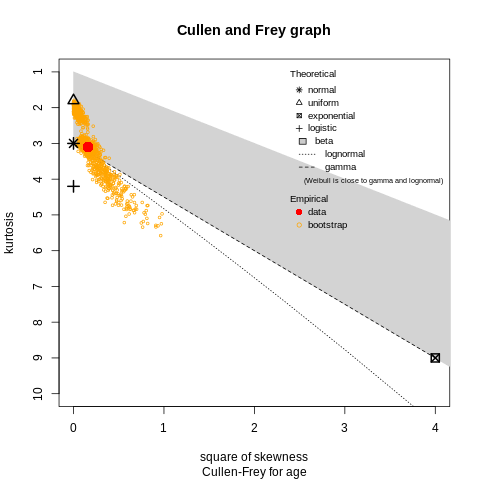

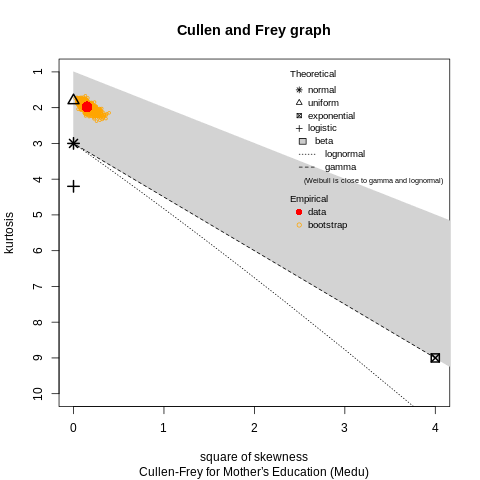

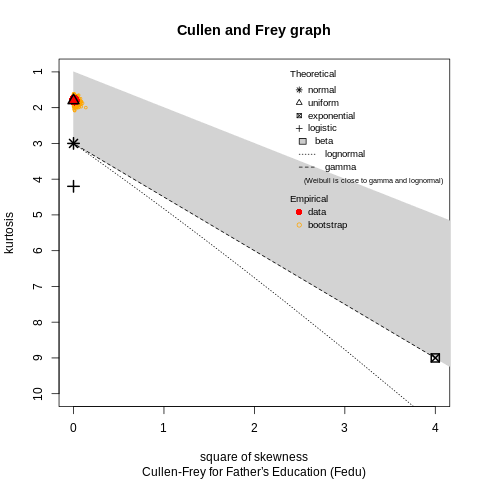

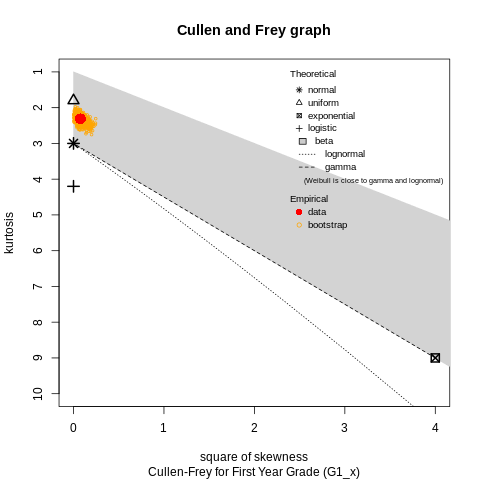

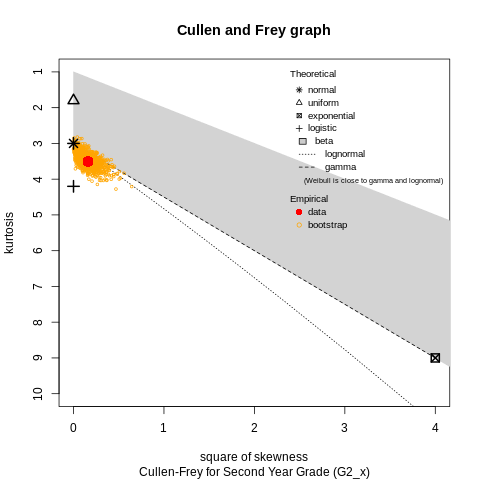

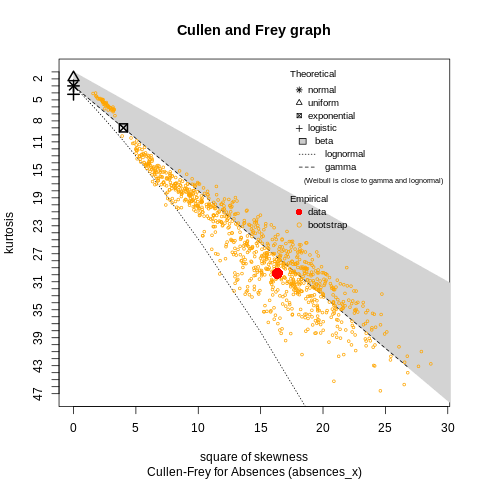

In [14]:
%%R

# variables = ['age', 'Medu', 'Fedu', 'G1_x', 'G2_x', 'absences_x']
set.seed(10) # for bootstrap

library("fitdistrplus")

# Cullen-Frey Graph
descdist(df$age, boot = 1000)
title(sub = "Cullen-Frey for age")

descdist(df$Medu, boot = 1000)
title(sub = "Cullen-Frey for Mother’s Education (Medu)")

descdist(df$Fedu, boot = 1000)
title(sub = "Cullen-Frey for Father’s Education (Fedu)")

descdist(df$G1_x, boot = 1000)
title(sub = "Cullen-Frey for First Year Grade (G1_x)")

descdist(df$G2_x, boot = 1000)
title(sub = "Cullen-Frey for Second Year Grade (G2_x)")

descdist(df$absences_x, boot = 1000)
title(sub = "Cullen-Frey for Absences (absences_x)")

# Fitting Distributions to Data with Fitter

In [16]:
!pip install fitter
from fitter import Fitter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.4 MB/s eta 0:00:00


## Age

The fitter results for age are interesting given gamma has the lowest (best) standard error but uniform has the lowest (best) AIC and BIC values. Lower standard error means more precision, but lower AIC and BIC indicates better balance between fit and model complexity. There is no correct answer, and given our age data is discrete, we will not transform it to maintain interpretability.

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,41.780215,827.487130,839.323392,inf,0.639119,3.300634e-152
lognorm,44.172774,939.402367,951.238629,inf,0.471232,2.377487e-78
norm,45.136218,783.424583,791.315424,inf,0.183735,9.271878e-12
uniform,46.480388,393.182030,401.072871,inf,0.537397,1.064526e-103


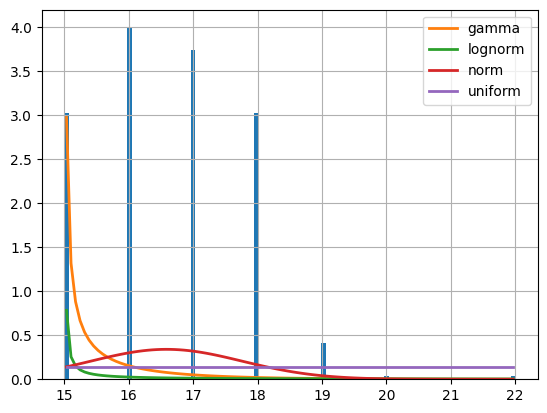

In [ ]:
plt.figure()
data_fit = Fitter(data['age'], distributions=[ 'norm', 'gamma', 'lognorm', 'uniform'])
data_fit.fit()
plt.title("Fitting for Age")
data_fit.summary()

## Mother's Education

For mother's education, uniform distribution is the best fit according to AIC and BIC. Beta has a lower sum squared error. Because mother's education is categorical, we will not transform.

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,152.877826,314.154317,329.935999,inf,0.353403,3.520471e-43
uniform,162.776342,281.258872,289.149713,inf,0.358639,1.702486e-44


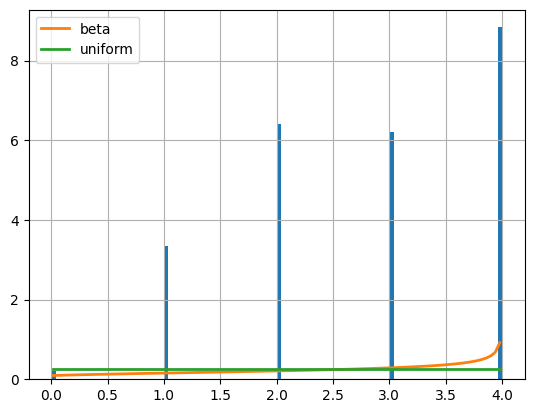

In [17]:
plt.figure()
data_fit = Fitter(data['Medu'], distributions=[ 'beta', 'uniform'])
data_fit.fit()
plt.title("Fitting for Mother's Education")
data_fit.summary()

## Father's Education

Based on AIC and BIC, uniform is a better fit. However, sum squared error is lower for beta. Because father's educaiton is categorical, we will not transform.

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,146.110632,306.442954,322.224636,inf,0.259162,4.048907e-23
uniform,150.338361,281.258872,289.149713,inf,0.293194,1.372170e-29


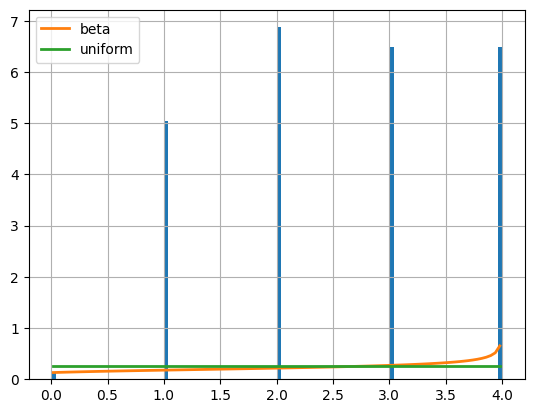

In [ ]:
plt.figure()
data_fit = Fitter(data['Fedu'], distributions=[ 'beta', 'uniform'])
data_fit.fit()
plt.title("Fitting for Father's Education")
data_fit.summary()

## First Year Grades

Normal distirbution is the best fitting distribution for first year grades. Given the fitter results and the original histogram of first year grades appeared to be normal, we will proceed with this variable without any transformation.


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,2.793287,623.130227,638.911909,inf,0.082659,0.010183
lognorm,2.798403,630.337118,642.173380,inf,0.086765,0.005960
norm,2.807064,620.108965,627.999806,inf,0.101601,0.000693


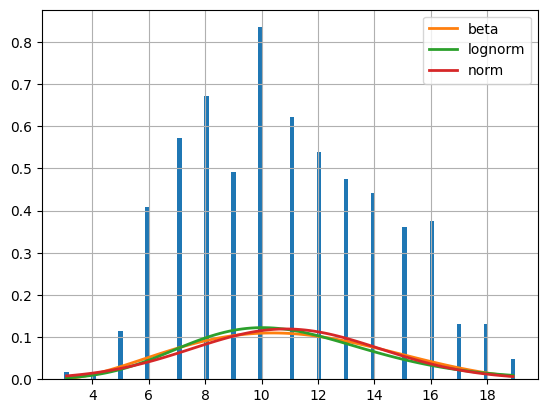

In [ ]:
plt.figure()
data_fit = Fitter(data['G1_x'], distributions=['norm', 'lognorm', 'beta'])
data_fit.fit()
plt.title("Fitting for First Year Grades")
data_fit.summary()

## Second Year Grades

Normal is the best distribution for second year grades according to both sum squared error, AIC, and BIC. We will proceed with this variable without any transformation as it is already normal.



,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,1.869168,671.585298,679.476139,inf,0.076022,2.291112e-02
gamma,1.870147,673.023240,684.859502,inf,0.089704,3.998000e-03
lognorm,2.259512,1564.433263,1576.269525,inf,0.538243,4.720030e-104


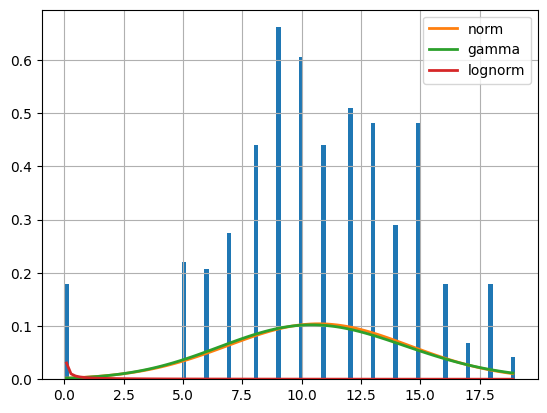

In [ ]:
# variables = ['age', 'Medu', 'Fedu', 'G1_x', 'G2_x', 'absences_x']
plt.figure()
data_fit = Fitter(data['G2_x'], distributions=['norm', 'lognorm', 'gamma'])
data_fit.fit()
plt.title("Fitting for Second Year Grades")
data_fit.summary()

## Absences

The exponential transformation is far supior when looking at AIC and BIC and also with sum squared error metric.

While this suggests we would want to perform an exponential transformation, we attempted that in the first draft of this project and it resulted in high p values as compared to the untransformed variable. Therefore, we will not transform this variable as the transformation does not strengthen the  model.

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,0.104154,5505.163954,5517.000215,inf,0.629202,6.780346e-147
expon,0.127672,1748.211985,1756.102826,inf,0.303665,9.402979e-32
lognorm,0.273238,2065.823210,2077.659472,inf,0.440251,6.242511e-68


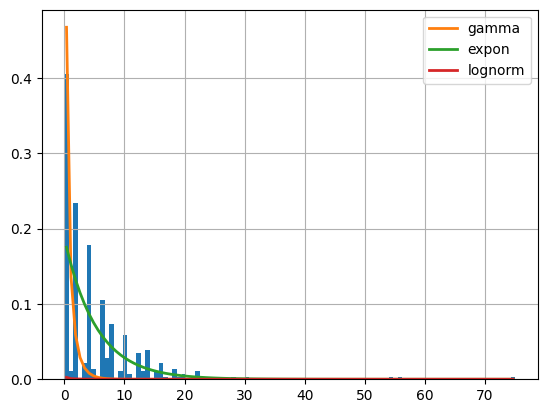

In [ ]:
plt.figure()
data_fit = Fitter(data['absences_x'], distributions=[ 'expon', 'lognorm', 'gamma'])
data_fit.fit()
plt.title("Fitting for Absences")
data_fit.summary()

# **Analysis**
- Overall, we will leave our data untransformed and in its original form. Given that most of our variables are discrete, with many being categorical, transforming the variables would result in a significant loss of economic interpretability. Therefore, we proceed without transfomations to preserve the economic meaning.

- We will also leave our first and second year grades as-is given they are close to normal.

# **Correlation Plot**

- G1 and G2 variables, which represent final grades in the 1st and 2nd year, are highly correlated. Due to the pontial multicollinearity problem in our model, we drop G1. Intuitively, grades from the 2nd year (G2) would be a better predictor for grades in the third year (G3), and their stronger relationship is confirmed in the correlation matrix above, showing the correlation of 72%. Additionally, mother's education is highly correlated with father's education (65%), which can be driven by the possibilty that people marry people with simiar education level. We drop Fedu and leave Medu in our model because the latter shows stronger correlation with out dependent variable, G3_binary (**pass/fail** ).

- Final list of predictors:
       'sex', 'age', 'famsize', 'Pstatus', 'Medu', 'traveltime_x',
       'studytime_x', 'schoolsup_x', 'famsup_x', 'paid_x', 'activities_x',
       'higher_x', 'romantic_x', 'famrel_x', 'freetime_x', 'goout_x', 'Walc_x',
       'absences_exp', 'G2_x'

                   sex       age   famsize   Pstatus      Medu      Fedu  \
sex           1.000000  0.017414  0.093052 -0.022820 -0.104516 -0.047654   
age           0.017414  1.000000 -0.010115  0.054353 -0.120663 -0.127846   
famsize       0.093052 -0.010115  1.000000  0.150407  0.015467  0.047306   
Pstatus      -0.022820  0.054353  0.150407  1.000000 -0.131896 -0.083989   
Medu         -0.104516 -0.120663  0.015467 -0.131896  1.000000  0.649797   
Fedu         -0.047654 -0.127846  0.047306 -0.083989  0.649797  1.000000   
traveltime_x -0.057311  0.102608 -0.059191  0.035409 -0.205895 -0.187856   
studytime_x   0.293137 -0.012225  0.059454  0.034100  0.050040 -0.003824   
schoolsup_x   0.147342 -0.235810  0.032591 -0.049546 -0.064700  0.015201   
famsup_x      0.158254 -0.122422  0.094605  0.012189  0.149883  0.169846   
paid_x        0.128773 -0.025939 -0.009571  0.063272  0.127198  0.076320   
activities_x -0.106849 -0.066495  0.020288  0.087492  0.110838  0.116586   
higher_x    

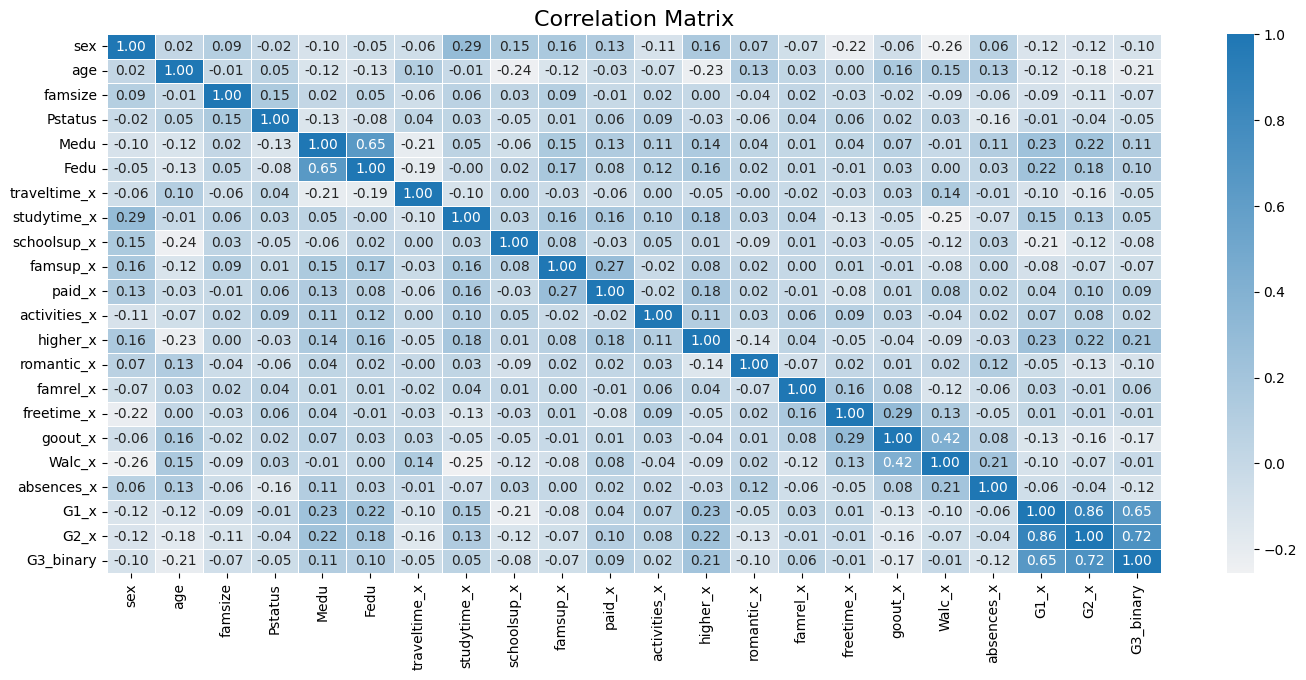

In [19]:
plt.figure(figsize=(17, 7))
C = describe.corr()
print(C)

blue_cmap = sns.light_palette("#1f77b4", as_cmap=True)
sns.heatmap(C, annot=True, cmap=blue_cmap, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix", fontsize=16)
plt.show()

In [ ]:
predictors = predictors.drop(columns=['Fedu', 'G1_x'])

# Boxplots

Second year grades seem to show the most singificant differences between people who fail versus people who fail in the third grade. Alcohol consumption on the weekends, absences and study time show a lot of overlap, suggesting a weak evidence that the less absences, the more study time and the less weekend activities on the weekend, the higher the chances of passing the mathematics class in the third grade.

<ipython-input-22-586dae8b2d78>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='G3_binary', y='absences_x', palette=custom_palette, ax=axes[0, 0])
<ipython-input-22-586dae8b2d78>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='G3_binary', y='Walc_x', palette=custom_palette, ax=axes[0, 1])
<ipython-input-22-586dae8b2d78>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='G3_binary', y='G2_x', palette=custom_palette, ax=axes[1, 0])
<ipython-input-22-586dae8b2d78>:25: FutureWarning: 

Passing `palette

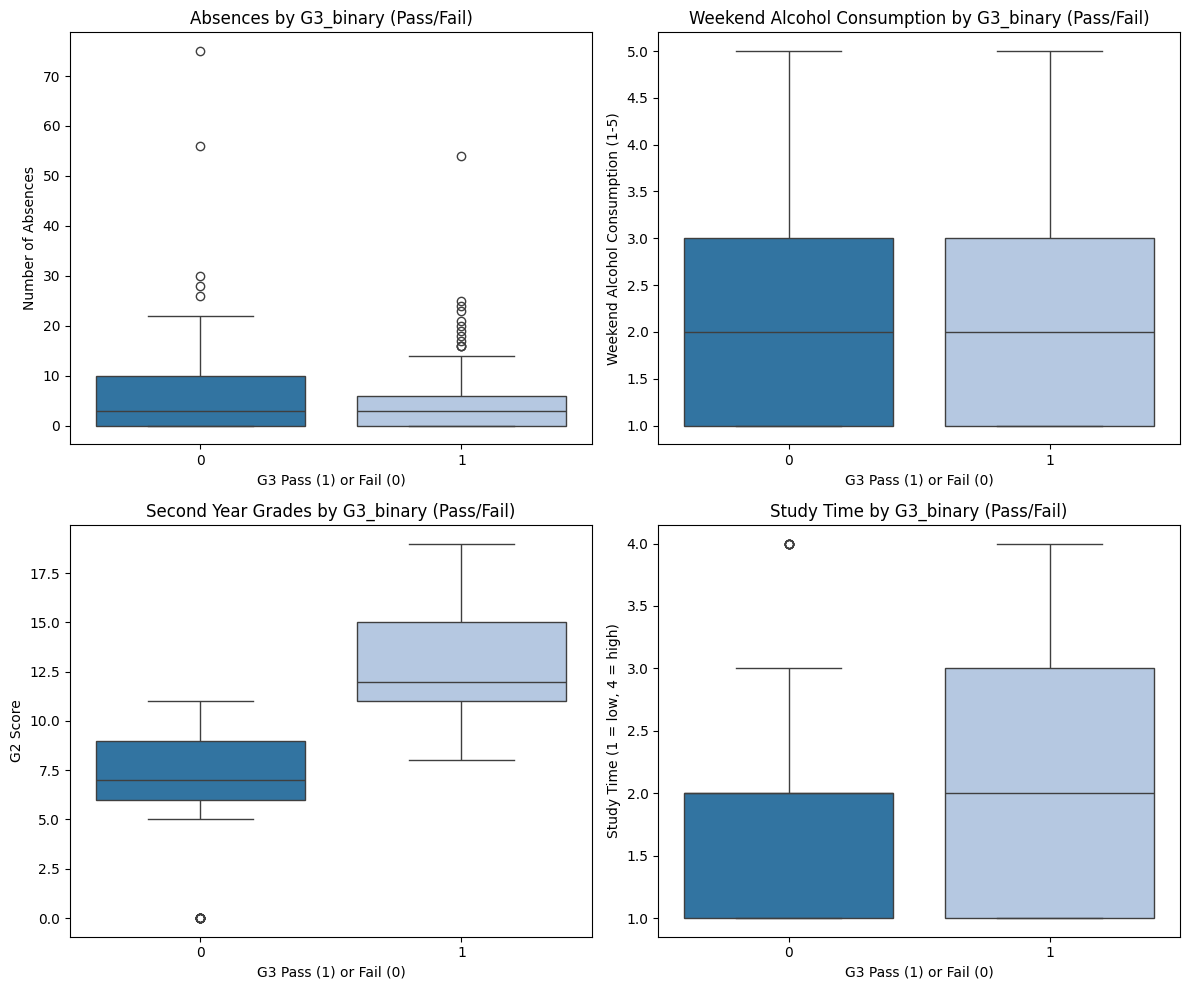

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

custom_palette = ['#1f77b4', '#aec7e8']

# Absences by G3_binary
sns.boxplot(data=data, x='G3_binary', y='absences_x', palette=custom_palette, ax=axes[0, 0])
axes[0, 0].set_title('Absences by G3_binary (Pass/Fail)')
axes[0, 0].set_xlabel('G3 Pass (1) or Fail (0)')
axes[0, 0].set_ylabel('Number of Absences')

# Weekend alcohol consumption by G3_binary
sns.boxplot(data=data, x='G3_binary', y='Walc_x', palette=custom_palette, ax=axes[0, 1])
axes[0, 1].set_title('Weekend Alcohol Consumption by G3_binary (Pass/Fail)')
axes[0, 1].set_xlabel('G3 Pass (1) or Fail (0)')
axes[0, 1].set_ylabel('Weekend Alcohol Consumption (1-5)')

# Second year grades by G3_binary
sns.boxplot(data=data, x='G3_binary', y='G2_x', palette=custom_palette, ax=axes[1, 0])
axes[1, 0].set_title('Second Year Grades by G3_binary (Pass/Fail)')
axes[1, 0].set_xlabel('G3 Pass (1) or Fail (0)')
axes[1, 0].set_ylabel('G2 Score')

# Study time by G3_binary
sns.boxplot(data=data, x='G3_binary', y='studytime_x', palette=custom_palette, ax=axes[1, 1])
axes[1, 1].set_title('Study Time by G3_binary (Pass/Fail)')
axes[1, 1].set_xlabel('G3 Pass (1) or Fail (0)')
axes[1, 1].set_ylabel('Study Time (1 = low, 4 = high)')

plt.subplots_adjust(hspace=0.9, wspace=0.9)
plt.tight_layout()

plt.show()

# **Scatterplots**

The figure on the left presents the relationship between the second year grades and passing/failing in the third grade conditioned on sex (sex=1 for women and sex=0 for men). The distribution of grades based on sexes does not reveal any particular pattern. On the other hand, the figure on the right, which explores the relationship between the amount spent studying and passing the math course, conditioned on travel time between school and home showed clear patterns. Students whose travel time was the highest, spent the least time studying. Nevertheless, the number of hours spent studying does not has a weak relationship with passing rate.

<ipython-input-25-b8e13bf70c73>:8: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=data, x='studytime_x', y='G3_binary', hue='traveltime_x', ax=axes[1], palette=custom_palette)


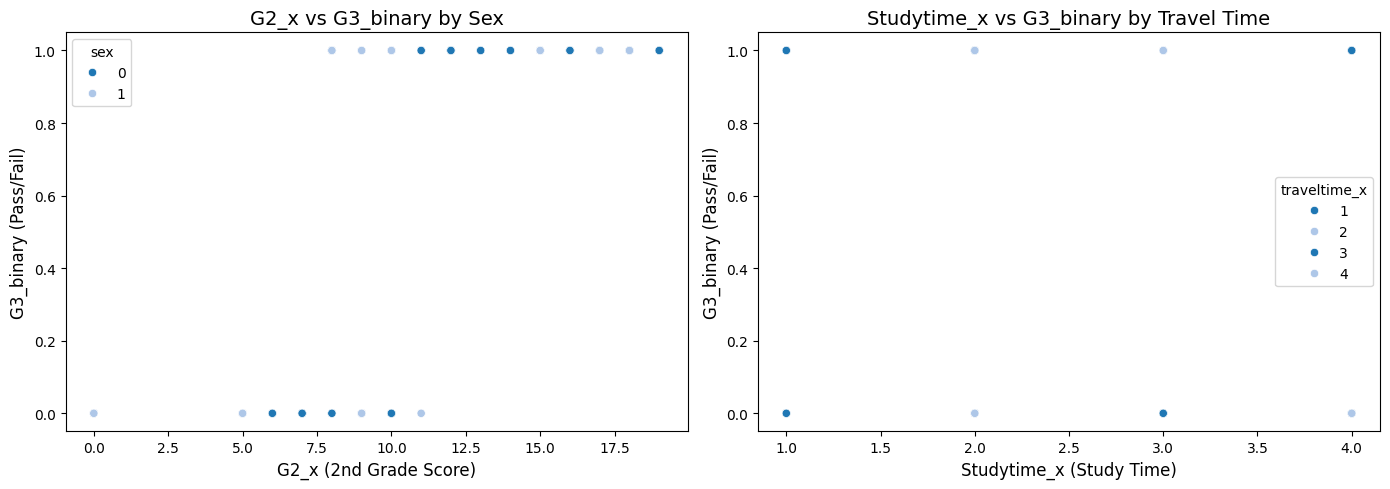

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(data=data, x='G2_x', y='G3_binary', hue='sex', ax=axes[0], palette=custom_palette)
axes[0].set_title('G2_x vs G3_binary by Sex', fontsize=14)
axes[0].set_xlabel('G2_x (2nd Grade Score)', fontsize=12)
axes[0].set_ylabel('G3_binary (Pass/Fail)', fontsize=12)

sns.scatterplot(data=data, x='studytime_x', y='G3_binary', hue='traveltime_x', ax=axes[1], palette=custom_palette)
axes[1].set_title('Studytime_x vs G3_binary by Travel Time', fontsize=14)
axes[1].set_xlabel('Studytime_x (Study Time)', fontsize=12)
axes[1].set_ylabel('G3_binary (Pass/Fail)', fontsize=12)

plt.tight_layout()
plt.show()


# **Models**

# **Linear Probability Model**

In [33]:
ols_model = smf.ols('G3_binary ~ sex + age + famsize + Pstatus + Medu + traveltime_x + studytime_x + schoolsup_x + famsup_x + paid_x + activities_x + higher_x + romantic_x + famrel_x + freetime_x + goout_x + Walc_x  + absences_x + G2_x', data=data).fit()
ols_model_summary = ols_model.summary()
ols_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              G3_binary   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     24.75
Date:                Sat, 18 Jan 2025   Prob (F-statistic):           4.75e-54
Time:                        22:20:49   Log-Likelihood:                -95.497
No. Observations:                 382   AIC:                             231.0
Df Residuals:                     362   BIC:                             309.9
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1366      0.309      0.441      0.659      -0.472       0.745
sex              0.0096      0.038      0.251      0.802      -0.066       0.085
age             -0.0339      0.016     -2.184      0.030      -0.064      -0.003
famsize          0.0243      0.038      0.641      0.522      -0.050       0.099
Pstatus         -0.0693      0.057     -1.208      0.228      -0.182       0.043
Medu            -0.0148      0.017     -0.887      0.376      -0.048       0.018
traveltime_x     0.0431      0.025      1.746      0.082      -0.005       0.092
studytime_x     -0.0162      0.022     -0.751      0.453      -0.059       0.026
schoolsup_x     -0.0118      0.051     -0.229      0.819      -0.113       0.089
famsup_x        -0.0246      0.037     -0.672      0.502      -0.097       0.047
paid_x           0.0207      0.036      0.577      0.564      -0.050       0.091
activities_x    -0.0295      0.034     -0.865      0.388      -0.097       0.038
higher_x         0.1087      0.085      1.278      0.202      -0.059       0.276
romantic_x       0.0190      0.037      0.518      0.605      -0.053       0.091
famrel_x         0.0439      0.018      2.374      0.018       0.008       0.080
freetime_x       0.0025      0.018      0.135      0.893      -0.033       0.038
goout_x         -0.0353      0.017     -2.065      0.040      -0.069      -0.002
Walc_x           0.0355      0.016      2.239      0.026       0.004       0.067
absences_x      -0.0058      0.002     -2.504      0.013      -0.010      -0.001
G2_x             0.0876      0.005     18.191      0.000       0.078       0.097
==============================================================================
Omnibus:                       95.467   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.932
Skew:                          -0.149   Prob(JB):                     7.74e-05
Kurtosis:                       1.951   Cond. No.                         421.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
ols_model2 = smf.ols('G3_binary ~ age + famrel_x + goout_x + traveltime_x + Walc_x + absences_x + G2_x', data=data).fit()
ols_model_summary2 = ols_model2.summary()
ols_model_summary2

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              G3_binary   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     67.25
Date:                Sat, 18 Jan 2025   Prob (F-statistic):           2.34e-62
Time:                        22:20:50   Log-Likelihood:                -98.887
No. Observations:                 382   AIC:                             213.8
Df Residuals:                     374   BIC:                             245.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1339      0.256      0.523      0.601      -0.370       0.637
age             -0.0344      0.014     -2.394      0.017      -0.063      -0.006
famrel_x         0.0421      0.018      2.347      0.019       0.007       0.077
goout_x         -0.0376      0.016     -2.323      0.021      -0.069      -0.006
traveltime_x     0.0444      0.024      1.851      0.065      -0.003       0.092
Walc_x           0.0374      0.015      2.563      0.011       0.009       0.066
absences_x      -0.0055      0.002     -2.512      0.012      -0.010      -0.001
G2_x             0.0873      0.004     19.877      0.000       0.079       0.096
==============================================================================
Omnibus:                      105.801   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.993
Skew:                          -0.169   Prob(JB):                     4.56e-05
Kurtosis:                       1.931   Cond. No.                         339.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
old_model2_predictions = ols_model2.predict(data)

In [36]:
from sklearn.metrics import classification_report

y_test = data['G3_binary']

# Convert probabilities to binary predictions
threshold = 0.5
predicted_classes_OLS = (old_model2_predictions >= threshold).astype(int)

# Classification report
print(classification_report(y_test, predicted_classes_OLS))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86       127
           1       0.92      0.95      0.93       255

    accuracy                           0.91       382
   macro avg       0.91      0.89      0.90       382
weighted avg       0.91      0.91      0.91       382



The above linear probability models use our independent variables to predict the binary outcome of passing (1) or failing (0) the third year of schooling. The second model takes the variables with statistically significant coefficients from the first, omitting the variables with previously insignificant coefficients. The second model is a slight improvement from the first and we will use it to assess accuracy and precision.

# **Probit Model**

In [37]:
model_probit = smf.probit('G3_binary ~ sex + age + famsize + Pstatus + Medu + traveltime_x + studytime_x + schoolsup_x + famsup_x + paid_x + activities_x + higher_x + romantic_x + famrel_x + freetime_x + goout_x + Walc_x  + absences_x + G2_x', data=data).fit(disp=0)
probit_summary = model_probit.summary()
print(probit_summary)

                          Probit Regression Results                           
Dep. Variable:              G3_binary   No. Observations:                  382
Model:                         Probit   Df Residuals:                      362
Method:                           MLE   Df Model:                           19
Date:                Sat, 18 Jan 2025   Pseudo R-squ.:                  0.7973
Time:                        22:20:54   Log-Likelihood:                -49.250
converged:                       True   LL-Null:                       -242.92
Covariance Type:            nonrobust   LLR p-value:                 1.881e-70
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -11.6699      3.705     -3.150      0.002     -18.932      -4.408
sex              0.2947      0.373      0.790      0.429      -0.436       1.026
age             -0.2922      0.157     -1.85

In [38]:
model_probit2 = smf.probit('G3_binary ~ age + famsize + Pstatus + traveltime_x + studytime_x + famrel_x + goout_x + Walc_x + G2_x', data=data).fit(disp=0)
probit_summary2 = model_probit2.summary()
print(probit_summary2)

                          Probit Regression Results                           
Dep. Variable:              G3_binary   No. Observations:                  382
Model:                         Probit   Df Residuals:                      372
Method:                           MLE   Df Model:                            9
Date:                Sat, 18 Jan 2025   Pseudo R-squ.:                  0.7659
Time:                        22:20:54   Log-Likelihood:                -56.874
converged:                       True   LL-Null:                       -242.92
Covariance Type:            nonrobust   LLR p-value:                 1.227e-74
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -10.1041      2.863     -3.529      0.000     -15.716      -4.492
age             -0.2863      0.131     -2.185      0.029      -0.543      -0.029
famsize          0.9144      0.346      2.64

In [39]:
# Generate predicted probabilities using the Probit model
probit_predictions = model_probit2.predict(data)  # Replace X_test with your test dataset

# Convert probabilities to binary predictions
threshold = 0.5
predicted_classes_probit = (probit_predictions >= threshold).astype(int)

# Generate the classification report
print(classification_report(y_test, predicted_classes_probit))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       127
           1       0.95      0.94      0.94       255

    accuracy                           0.93       382
   macro avg       0.92      0.92      0.92       382
weighted avg       0.93      0.93      0.93       382



# **Logit Model**

In [ ]:
logit_model = smf.logit('G3_binary ~ sex + age + famsize + Pstatus + Medu + traveltime_x + studytime_x + schoolsup_x + famsup_x + paid_x + activities_x + higher_x + romantic_x + famrel_x + freetime_x + goout_x + Walc_x  + absences_x + G2_x', data=data).fit(disp=0)
logit_summary = logit_model.summary()
print(logit_summary)

                           Logit Regression Results                           
Dep. Variable:              G3_binary   No. Observations:                  382
Model:                          Logit   Df Residuals:                      362
Method:                           MLE   Df Model:                           19
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                  0.7952
Time:                        21:51:38   Log-Likelihood:                -49.743
converged:                       True   LL-Null:                       -242.92
Covariance Type:            nonrobust   LLR p-value:                 3.014e-70
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -19.8357      6.633     -2.990      0.003     -32.837      -6.835
sex              0.5749      0.671      0.857      0.391      -0.740       1.890
age             -0.5334      0.289     -1.84

In [ ]:
logit_model2 = smf.logit('G3_binary ~ famsize + traveltime_x + studytime_x + famrel_x + goout_x + Walc_x + G2_x', data=data).fit(disp=0)
logit_summary2 = logit_model2.summary()
print(logit_summary2)

                           Logit Regression Results                           
Dep. Variable:              G3_binary   No. Observations:                  382
Model:                          Logit   Df Residuals:                      374
Method:                           MLE   Df Model:                            7
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                  0.7493
Time:                        23:38:45   Log-Likelihood:                -60.902
converged:                       True   LL-Null:                       -242.92
Covariance Type:            nonrobust   LLR p-value:                 1.221e-74
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -25.6256      4.191     -6.115      0.000     -33.839     -17.412
famsize          1.1800      0.571      2.065      0.039       0.060       2.300
traveltime_x     0.7174      0.314      2.28

In [ ]:
# Generate predicted probabilities using the Probit model
logit_predictions = logit_model2.predict(data)  # Replace X_test with your test dataset

# Convert probabilities to binary predictions
predicted_classes_logit = (logit_predictions >= threshold).astype(int)

# Generate the classification report
print(classification_report(y_test, predicted_classes_logit))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       127
           1       0.94      0.95      0.94       255

    accuracy                           0.92       382
   macro avg       0.92      0.91      0.91       382
weighted avg       0.92      0.92      0.92       382



# Analysis

For the above models, we used used the prior variable analysis and refinement based on p-values of predictors to identify the best-fitting model for each of three types - linear probabilty, probit, and logit. The second model of each type is in an effort to simplify the models to include variables that are specifically statistically significant (or almost statistically significant).

Then, we performed a prediction test on the second attempt models for each of the three types, linear probabilty, probit, and logit.  We use the 50% threshold, which is the threshold for passing G3.

*   Linear Probability and Probit models both have 91% weighted average for accuracy.  
*   Logit model has a 92% weighted average for accuracy.

Given that the logit model is slightly better, we will use it for our predictions.



# **Predictions using the Logit Model and Conclusion**

In [ ]:
#create predictions
prediction1 = pd.DataFrame({
    'famsize': [1],
    'traveltime_x': [4],
    'studytime_x': [1],
    'famrel_x': [1],
    'goout_x': [5],
    'Walc_x': [5],
    'G2_x': [10]})

prediction2 = pd.DataFrame({
    'famsize': [1],
    'traveltime_x': [4],
    'studytime_x': [1],
    'famrel_x': [1],
    'goout_x': [5],
    'Walc_x': [5],
    'G2_x': [9]})

prediction3 = pd.DataFrame({
    'famsize': [0],
    'traveltime_x': [1],
    'studytime_x': [4],
    'famrel_x': [5],
    'goout_x': [1],
    'Walc_x': [1],
    'G2_x': [9]})

prediction4 = pd.DataFrame({
    'famsize': [1],
    'traveltime_x': [2],
    'studytime_x': [3],
    'famrel_x': [3],
    'goout_x': [2],
    'Walc_x': [2],
    'G2_x': [11]})

In [ ]:
#predict probabilities for predictions
predicted_prob1 = logit_model2.predict(prediction1)[0]
predicted_prob2 = logit_model2.predict(prediction2)[0]
predicted_prob3 = logit_model2.predict(prediction3)[0]
predicted_prob4 = logit_model2.predict(prediction4)[0]

In [ ]:
#combine predictions into a DataFrame for comparison
comparison = pd.DataFrame({
    'Case': ['Prediction 1', 'Prediction 2', 'Prediction 3', 'Prediction 4'],
    'Predicted Probability': [predicted_prob1, predicted_prob2, predicted_prob3, predicted_prob4]
})

comparison['Classification'] = (comparison['Predicted Probability'] >= 0.5).astype(int)
comparison

,Case,Predicted Probability,Classification
0,Prediction 1,0.813248,1
1,Prediction 2,0.282379,0
2,Prediction 3,0.292562,0
3,Prediction 4,0.983109,1


# **Interpretation**
- The above predictions illustrate an interesting dynamic in our model. Essentially, a G2 passing grade seems to be the most important thing for a G3 passing prediction.  

- Prediction one and two illustrate that the lowest possible passing score for G2 (10)  **greatly increases** the probability of passing G3, even if all other variables are at their worst possible level (larger family, long travel time, little study time, poor familial relationships, goes out often, consumes a lot of alcohol). The only difference between prediction 1 and 2 are G2 scores - Prediction 1 has a G2 score of 10 whereas Prediction 2 has a G2 score of 9. this one point difference dramatically affects the predicted probabilty, from 81% prob of passing down to 28% prob.

- This makes sense given the strong correlation we saw in the correlation plot between G2 and our G3_binary.

- Predictions 3 and 4 illustrate a similar pattern, but with less extreme independent variable values. Prediction 3 suggests that even if someone were to have an ideal set up (only child, short travel time, a lot of study time, strong familial relationships, does not go out often, does not consumes a lot of alcohol), if they scored a 9 (highest failing score) they still are not predicted to pass. Prediction 4 suggests that even with moderate other elements, scoring an 11 in G2 suggests strong liklihood of passing.

- Given that all four predictions are in or near the upper and lower quartiles (<25% and >75%), we have confidence in these predictions. It also makes sense that the G2 score would so greatly affect the predictions given the high correlation between G2 and G3 binary as illustrated in correleation plots.